In [1]:
import os
import netCDF4 as nc
import numpy as np
import pandas as pd

import copy

import scipy.io as io

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib import colors, colorbar

from skimage import measure
from skimage.filters import gaussian

from impdar import *
from autopicker_methods import *

In [2]:
#files on disk
green_mat = '../data/nline5_migtk_cropped.mat'

#load in data
dat = load.load('mat', green_mat)[0]

### Inspect the data

In [3]:
dat

In [4]:
vars(dat)

{'chan': 1,
 'data': array([[ 1.7062012e+02,  3.4430664e+02,  5.2520801e+02, ...,
          4.9876855e+02,  3.2267871e+02,  1.6024463e+02],
        [ 1.6782129e+02,  3.3955762e+02,  5.1817383e+02, ...,
          4.9146289e+02,  3.1805176e+02,  1.5720459e+02],
        [ 1.6507324e+02,  3.3474707e+02,  5.1118945e+02, ...,
          4.8423926e+02,  3.1333301e+02,  1.5422656e+02],
        ...,
        [ 9.9792108e-03,  1.2658692e-02,  1.2822898e-02, ...,
          4.6563488e-03, -1.3017319e-03, -4.2040930e-03],
        [-3.8737059e-04,  2.3204908e-03,  6.2305406e-03, ...,
         -4.9580783e-03, -5.0620083e-03, -4.6427697e-03],
        [-2.5235116e-04, -6.2930584e-04, -7.8973547e-04, ...,
         -6.2405951e-03, -5.2189473e-03, -4.2466298e-03]], dtype=float32),
 'decday': array([nan, nan, nan, ..., nan, nan, nan]),
 'dt': 5e-09,
 'lat': array([75.7803409 , 75.78029846, 75.78025468, ..., 75.56009747,
        75.56005895, 75.56002065]),
 'long': array([-36.49250295, -36.49226244, -36.49202

In [5]:
dat.picks

In [6]:
vars(dat.picks)

{'samp1': None,
 'samp2': None,
 'samp3': None,
 'time': None,
 'power': None,
 'picknums': [0],
 'lasttrace': <impdar.lib.LastTrace.LastTrace at 0x7f189b664f98>,
 'lt': <impdar.lib.LeaderTrailer.LeaderTrailer at 0x7f189b664748>,
 'pickparams': <impdar.lib.PickParameters.PickParameters at 0x7f18901b0278>,
 'radardata': <impdar.lib.RadarData.RadarData at 0x7f189b6645c0>,
 'lines': []}

### Plot the data in ImpDAR

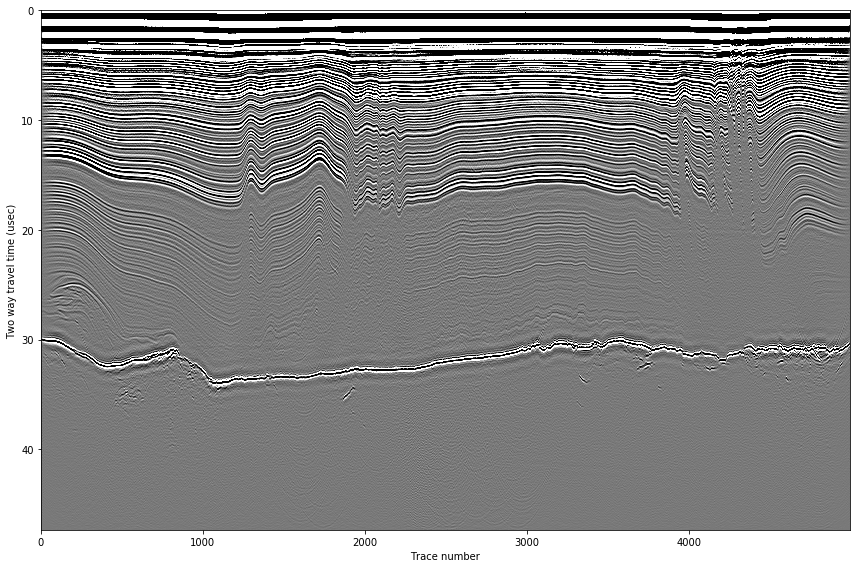

In [7]:
plot.plot(green_mat)

### Let's see if we can use our autopicking methods on ImpDAR RadarData objects

The general processing flow should be something like this:
- Find the contours for a certain value.
- Find the left- and right-most x values in a contour, and use them to find the unique x values that span each contour.
- Find the central points inside the contours (maximima for ridges, minima for troughs), and get rid of those points for which we have less than two or more than three y values for each unique x value along the contour.
- Check to make sure that our unique x and central value list have non-zero lengths, meaning that we were able to find values for that contour. Note: for some contours along the top of the profile, this method is sometimes unable to find central values and thus we should not include them.
- Check to make sure that our unique x and central value lists have the same length
- Then find the top and bottom of the wave packet so that we can calculate power for each pick (which is what I would consider what we have at this point).

The whole process should be more or less automatic. It is recommended that the user look along a track beforehand to pick the value in the `find_contours()` method.

In [8]:
contours = find_contours(dat, 3)

In [9]:
contours

[array([[3.47025954e+01, 4.99000000e+03],
        [3.50000000e+01, 4.98997335e+03],
        [3.60000000e+01, 4.98987877e+03],
        ...,
        [3.80000000e+01, 9.84381268e-02],
        [3.70000000e+01, 5.71228654e-03],
        [3.69356133e+01, 0.00000000e+00]]),
 array([[1.54080043e+02, 0.00000000e+00],
        [1.55000000e+02, 1.45353066e-01],
        [1.56000000e+02, 4.20486508e-01],
        ...,
        [1.53000000e+02, 4.98970504e+03],
        [1.52000000e+02, 4.98987525e+03],
        [1.51213285e+02, 4.99000000e+03]]),
 array([[2.68058357e+02, 4.99000000e+03],
        [2.69000000e+02, 4.98977706e+03],
        [2.70000000e+02, 4.98951173e+03],
        ...,
        [2.77000000e+02, 3.35285985e-01],
        [2.76000000e+02, 1.67539514e-01],
        [2.75170753e+02, 0.00000000e+00]]),
 array([[3.87054444e+02, 0.00000000e+00],
        [3.88000000e+02, 2.19112209e-01],
        [3.89000000e+02, 4.70965375e-01],
        ...,
        [3.90000000e+02, 4.98948037e+03],
        [3.8900000

Here are some caveats to this method:
- For especially noisy profiles, this contouring method will not yield desirable results. This method is only as good as the processing steps that proceed it.
- That being said, this method works best for ice sheet data with planar, visibly continuous layers.
- Picks near the bed are not classified well. However, this method is not currently meant to pick the bed, but only internal reflectors. There are already a plethora of methods for picking the surface and bed of a radargram, although they are not currently implemented with this autopicking method.
- The fully automatic picker will pick contours below the bed since we are using an image processing approach: the autopicker does currently discern between what is and what isn't the bed-rock interface, it simply looks at "pixel" values.

It is my hope that this tutorial has been a sufficient walk-through of how the current automatic picker works, so that future collaborators can either expand upon or draw from the current implementation.